# My Favorite Pet

In [46]:
import os
# import cv2
import random
import numpy as np
import pandas as pd
# from tqdm import tqdm
# import pathlib
from pathlib import Path
from PIL import Image
# import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import random_split
# from torch.utils.data import DataLoader, Dataset, Subset
# from torch.utils.data import random_split, SubsetRandomSampler
# from torchvision import datasets, transforms, models 
# from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor
# from torchvision.utils import make_grid
# from pytorch_lightning import LightningModule
# from pytorch_lightning import Trainer
# import pytorch_lightning as pl
# import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Data Exploration

In [4]:
data_path = './Data/mammals/'
mammals = [f.name for f in os.scandir(data_path) if f.is_dir()]
# mammals_data_url = [data_url + mammal for mammal in mammals]
# mammals_data_url
mammals

['cat', 'dog', 'bear', 'tiger', 'goat', 'wolf', 'horse', 'lion', 'elephant']

### Separate dog data

In [5]:
dog_root = data_path + 'dog/'
dog_url = [dog_root+dog for dog in os.listdir(dog_root)]
dog_url.remove(dog_root + '.DS_Store')
dog_data = [Image.open(dog) for dog in dog_url]

## Example of how to read the image as numpy array

In [6]:
dog_1 = Image.open(dog_url[1])
# "thumbnail" is to shrink the image wihile keeping the aspect ratio
dog_1.thumbnail((100, 100))
dog_1.show()

In [5]:
# "reduced" is to shrink the image resolution by dividing the given value
dog_1_re = dog_1.reduce((10, 10))
dog_1_re.show()

In [6]:
dog_0 = Image.open(dog_url[0])
# "resize" is to shrink the image to a given size
dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)
dog_0_r.show()

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_65357/305650333.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  dog_0_r = dog_0.resize((180, 180), Image.ANTIALIAS)


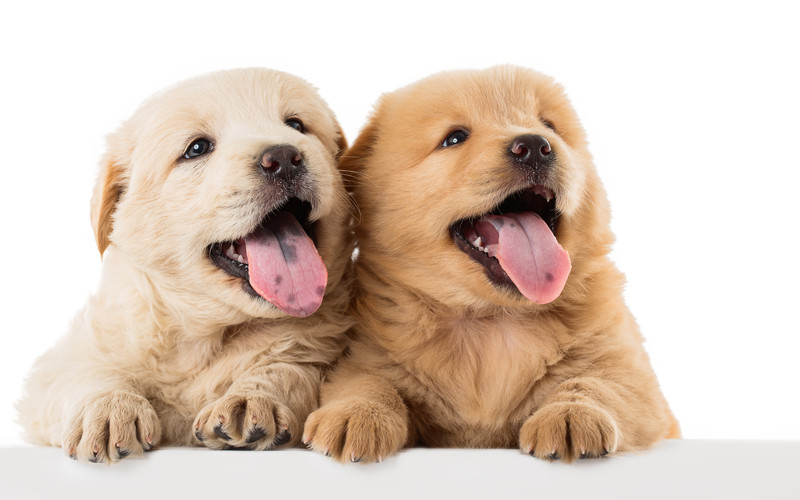

In [7]:
Image.open(dog_url[1])

# Data Preparation

### Loading data into a pandas data frame with one column of file paths and one column of labels

In [160]:
direc = Path('./Data/mammals')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))


filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,Data/mammals/cat/00000029.jpg,cat
1,Data/mammals/dog/00000057.jpg,dog
2,Data/mammals/goat/00000003.jpg,goat
3,Data/mammals/dog/00000037.jpg,dog
4,Data/mammals/dog/00000079.jpg,dog


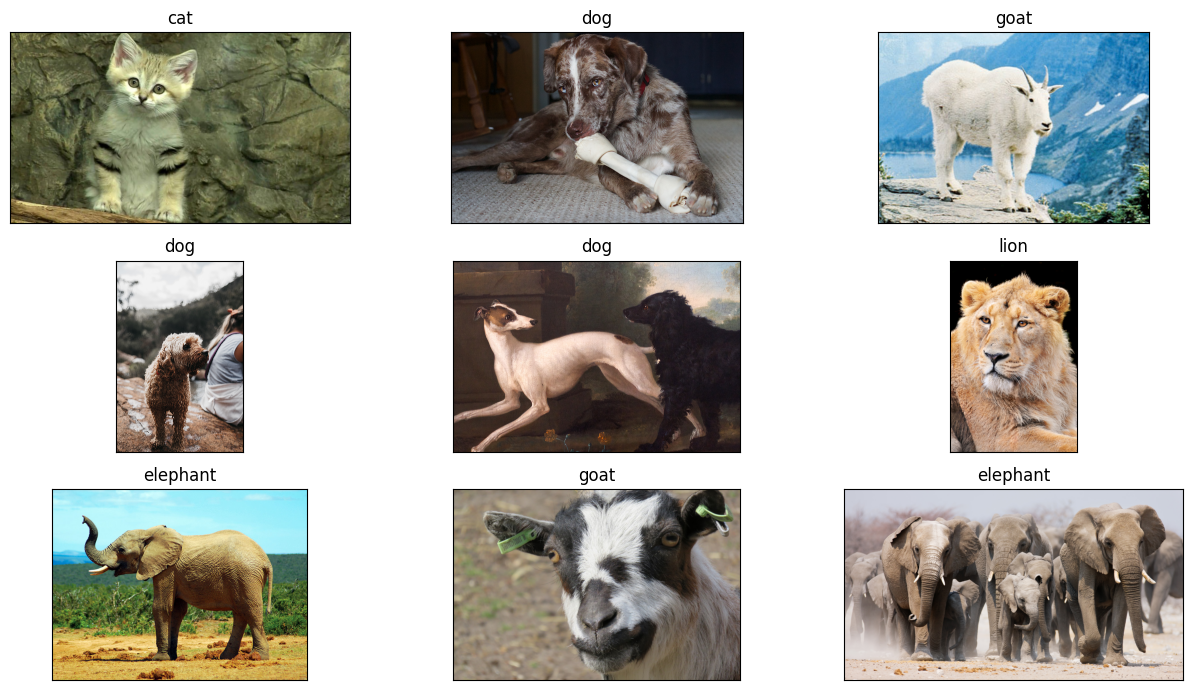

In [109]:
f, a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

### Split training data

In [110]:
def divide_data(img_df, dog_or_cat='dog'):
    if dog_or_cat not in ['dog', 'cat']:
        raise ValueError("Invalid value for dog_or_cat. It should be either 'dog' or 'cat'.")
    main_animal_df = img_df[img_df.Labels==dog_or_cat]
    half = img_df.shape[0] // 2
    if dog_or_cat == 'dog':
        slice_animals = slice(0, half)
    else:
        slice_animals = slice(half, -1)
    all_animals_df = img_df[~img_df.Labels.isin(['dog', 'cat'])][slice_animals].sample(n = main_animal_df.shape[0], random_state=42)
    # all_animals_df = img_df[~img_df.Labels.isin(['dog', 'cat'])].sample(n = main_animal_df.shape[0], random_state=42)[slice_animals]
    df = pd.concat([main_animal_df, all_animals_df]).sample(frac = 1, random_state=42)
    df['y'] = df.Labels == dog_or_cat
    return df

In [161]:
dog_train = divide_data(img_df, dog_or_cat='dog')
print(type(dog_train))
print('Training set size:', dog_train.shape)
print('Training set statistics', dog_train.Labels.value_counts())
print(dog_train.y.value_counts())
dog_train.head()

<class 'pandas.core.frame.DataFrame'>
Training set size: (190, 3)
Training set statistics Labels
dog         95
goat        23
elephant    15
bear        14
wolf        14
horse       12
tiger        9
lion         8
Name: count, dtype: int64
y
False    95
True     95
Name: count, dtype: int64


,FilePaths,Labels,y
7,Data/mammals/goat/00000023.jpg,goat,False
84,Data/mammals/horse/00000076.jpg,horse,False
486,Data/mammals/tiger/00000006.jpg,tiger,False
516,Data/mammals/dog/00000016.jpg,dog,True
489,Data/mammals/bear/00000006.jpg,bear,False


## Resize images by padding

In [112]:
def resize_image(pil_img, new_width=100, new_height=100, color='white'):
    right = left = top = bottom = 0
    width, height = pil_img.size
    if width > new_width and height > new_height:
        return pil_img.resize((100, 100))
    elif width < new_width:
        w = new_width - width
        left = w //2
        right = w - left
    elif height < new_height:
        h = new_height - height
        top = h //2
        bottom = h - top
        
    # new_width = width + right + left
    # new_height = height + top + bottom
    img_pad = Image.new(pil_img.mode, (new_width, new_height), color)
    img_pad.paste(pil_img, (left, top), mask=pil_img)
    return img_pad

In [162]:
# pass all the input samples to the a new pandas.DataFrame where the first column is the image matrix and the second column is the labels the third column is the target binary values
# Resize the images, suppose the size of every given image is greater than 100 x 100
def read_image_matrix(img_path, new_size=(50, 50)):
    # read the image path fron the first column of the dataframe then read the image as a matrix
    try:
        img = Image.open(img_path)
        img_resize = img.resize(size=new_size)
        img_matrix = np.array(img_resize)
        return img_matrix
    except:
        return None
# add a new column to the dataframe where the value is the image matrix
dog_train['Matrix'] = dog_train['FilePaths'].apply(read_image_matrix)

In [163]:
dog_train.head()

,FilePaths,Labels,y,Matrix
7,Data/mammals/goat/00000023.jpg,goat,False,"[[[131, 118, 99], [137, 127, 107], [138, 132, ..."
84,Data/mammals/horse/00000076.jpg,horse,False,"[[[100, 116, 78], [108, 120, 86], [112, 126, 8..."
486,Data/mammals/tiger/00000006.jpg,tiger,False,"[[[155, 151, 156], [153, 148, 149], [152, 148,..."
516,Data/mammals/dog/00000016.jpg,dog,True,"[[[49, 62, 5], [45, 67, 5], [43, 59, 8], [46, ..."
489,Data/mammals/bear/00000006.jpg,bear,False,"[[[53, 50, 50], [70, 63, 61], [101, 88, 79], [..."


In [165]:
# find how many images are corrupted
i = 0
for img in dog_train['Matrix']:
    if np.array(img).shape not in [(50, 50, 3)]:
        i += 1

print(i)

4


In [166]:
# Clean the data by removing the damaged images
dog_train = dog_train[dog_train['Matrix'].apply(lambda x: np.array(x).shape == (50, 50, 3))]
dog_train.reset_index(drop=True, inplace=True)

In [167]:
dog_img_mat = pd.DataFrame({'image_matrix': dog_train['Matrix'], 'label': dog_train['y']})
dog_img_mat['label'] = dog_img_mat['label'].astype(int)
dog_img_mat.head()

,image_matrix,label
0,"[[[131, 118, 99], [137, 127, 107], [138, 132, ...",0
1,"[[[100, 116, 78], [108, 120, 86], [112, 126, 8...",0
2,"[[[155, 151, 156], [153, 148, 149], [152, 148,...",0
3,"[[[49, 62, 5], [45, 67, 5], [43, 59, 8], [46, ...",1
4,"[[[53, 50, 50], [70, 63, 61], [101, 88, 79], [...",0


In [168]:
# check the statistics
print('Statistics: ', dog_img_mat.label.value_counts())
print('Size of processed images: ', dog_img_mat.iloc[1]['image_matrix'].shape)
print('An image matrix example: ', dog_img_mat.iloc[1]['image_matrix'])

Statistics:  label
0    93
1    93
Name: count, dtype: int64
Size of processed images:  (50, 50, 3)
An image matrix example:  [[[100 116  78]
  [108 120  86]
  [112 126  86]
  ...
  [112 141  83]
  [108 132  81]
  [103 129  81]]

 [[ 99 121  80]
  [105 121  81]
  [107 119  86]
  ...
  [113 134  85]
  [102 124  78]
  [ 95 119  72]]

 [[ 91 116  70]
  [104 126  83]
  [102 128  83]
  ...
  [109 127  87]
  [105 123  84]
  [101 120  80]]

 ...

 [[ 85 101  59]
  [ 87 104  65]
  [ 87 110  71]
  ...
  [100 122  74]
  [ 93 114  73]
  [ 86 110  76]]

 [[ 83  98  63]
  [ 91 111  69]
  [ 89 113  73]
  ...
  [100 123  74]
  [ 99 115  74]
  [ 83 108  58]]

 [[ 79  96  65]
  [ 79  99  60]
  [ 82 109  63]
  ...
  [ 84 105  63]
  [ 92 114  67]
  [ 93 110  68]]]


one dog image and one non-dog image are removed due to damage reason

## Train a Convolutional Neural Network for Classification

### Prepare the training data

In [169]:
# dog_img_mat['image_matrix'].fillna(255)
X_train = np.stack(dog_img_mat['image_matrix'].values)
X_train = X_train.astype('float32') / 255.0
X_train = X_train.reshape(-1, 50, 50, 3)

y_train = dog_img_mat['label'].values

In [170]:
# Split the data set into training and testing sets.
# We have a small dataset, so we decide not to have validation set.
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Build CNN model

In [171]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

In [173]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
# with dropout
model_with_dropout = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [174]:
reset_seeds()

In [175]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
print('*****************************************************************')
model_with_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_with_dropout.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 18432)             0         
                                                                 
 dense_54 (Dense)            (None, 64)                1179712   
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1180673 (4.50 MB)
Trainable params: 1180673 (4.50 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

 max_pooling2d_25 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 flatten_25 (Flatten)        (None, 18432)             0         
                                                                 
 dense_56 (Dense)            (None, 64)                1179712   
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1180673 (4.50 MB)
Trainable params: 1180673 (4.50 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

In [176]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


2023-06-18 22:04:18.738921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 162ms/step - loss: 2.5511 - accuracy: 0.4527
Epoch 2/20
5/5 [==============================] - 0s 35ms/step - loss: 1.3863 - accuracy: 0.5135
Epoch 3/20
5/5 [==============================] - 0s 44ms/step - loss: 1.1522 - accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.8737 - accuracy: 0.4797
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.9358 - accuracy: 0.4865
Epoch 6/20
5/5 [==============================] - 0s 25ms/step - loss: 0.7204 - accuracy: 0.5338
Epoch 7/20
5/5 [==============================] - 0s 19ms/step - loss: 0.7297 - accuracy: 0.5270
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.7157 - accuracy: 0.5676
Epoch 9/20
5/5 [==============================] - 0s 20ms/step - loss: 0.6695 - accuracy: 0.5811
Epoch 10/20
5/5 [==============================] - 0s 66ms/step - loss: 0.6558 - accuracy: 0.5946
Epoch 11/20
5/5 [======================

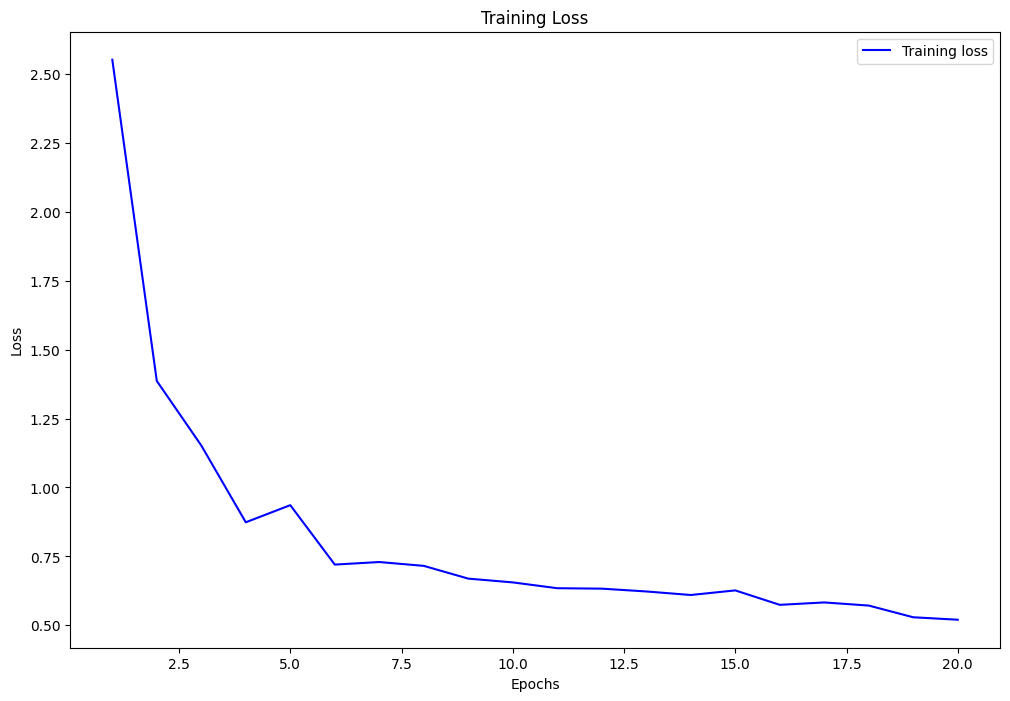

In [177]:
plt.figure(figsize=(12,8))

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# plot the training loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [178]:
history = model_with_dropout.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 1/40


2023-06-18 22:04:31.099061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 156ms/step - loss: 2.1736 - accuracy: 0.4595
Epoch 2/40
5/5 [==============================] - 0s 53ms/step - loss: 1.8767 - accuracy: 0.5676
Epoch 3/40
5/5 [==============================] - 0s 28ms/step - loss: 1.9048 - accuracy: 0.5676
Epoch 4/40
5/5 [==============================] - 0s 15ms/step - loss: 2.0755 - accuracy: 0.5608
Epoch 5/40
5/5 [==============================] - 0s 19ms/step - loss: 2.4053 - accuracy: 0.4797
Epoch 6/40
5/5 [==============================] - 0s 26ms/step - loss: 2.2923 - accuracy: 0.5068
Epoch 7/40
5/5 [==============================] - 0s 22ms/step - loss: 1.6105 - accuracy: 0.5676
Epoch 8/40
5/5 [==============================] - 0s 16ms/step - loss: 1.6117 - accuracy: 0.5405
Epoch 9/40
5/5 [==============================] - 0s 16ms/step - loss: 1.6393 - accuracy: 0.5743
Epoch 10/40
5/5 [==============================] - 0s 41ms/step - loss: 1.1871 - accuracy: 0.6486
Epoch 11/40
5/5 [======================

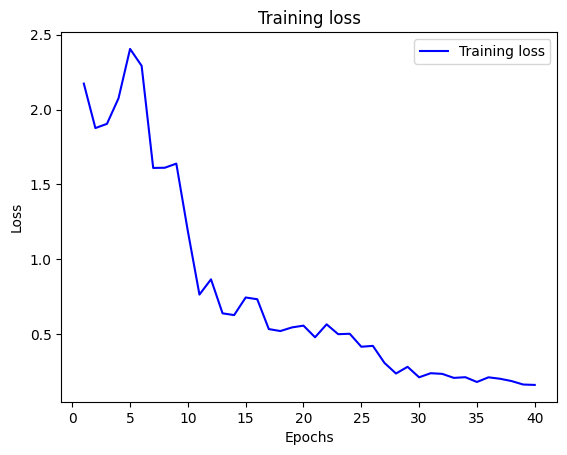

In [179]:
# plot the training loss
import matplotlib.pyplot as plt
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# plot the training loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [180]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

1/2 [==============>...............] - ETA: 0s - loss: 0.7471 - accuracy: 0.3750

2023-06-18 22:04:42.361990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 165ms/step - loss: 0.7401 - accuracy: 0.4474
Loss:  0.7401462197303772
Accuracy:  0.44736841320991516


In [181]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_hat = (y_pred > 0.5).astype("int32")

print(classification_report(y_test, y_hat))

2/2 [==============================] - 0s 57ms/step
              precision    recall  f1-score   support

           0       0.50      0.52      0.51        21
           1       0.38      0.35      0.36        17

    accuracy                           0.45        38
   macro avg       0.44      0.44      0.44        38
weighted avg       0.44      0.45      0.45        38



2023-06-18 22:05:04.188170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [182]:
loss, accuracy = model_with_dropout.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

2023-06-18 22:05:09.335972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 126ms/step - loss: 1.5426 - accuracy: 0.3947
Loss:  1.5425878763198853
Accuracy:  0.3947368562221527


In [183]:
y_pred = model_with_dropout.predict(X_test)
y_hat = (y_pred>0.5).astype("int32")
print(classification_report(y_test, y_hat))

2/2 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.40      0.19      0.26        21
           1       0.39      0.65      0.49        17

    accuracy                           0.39        38
   macro avg       0.40      0.42      0.37        38
weighted avg       0.40      0.39      0.36        38



2023-06-18 22:05:12.487980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Try Vision Transformer to build a classification model

In [184]:
from tensorflow.keras.applications import EfficientNetB0

In [195]:
def build_vit_model():
    inputs = layers.Input(shape=(50, 50, 3))
    base_model = EfficientNetB0(include_top=False, weights=None, input_tensor=inputs)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

vit_model = build_vit_model()
vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vit_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 50, 50, 3)            0         ['input_6[0][0]']             
                                                                                                  
 normalization_5 (Normaliza  (None, 50, 50, 3)            7         ['rescaling_5[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 51, 51, 3)            0         ['normalization_5[0][0]'

In [194]:
reset_seeds()

In [196]:
history = vit_model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/4


2023-06-18 22:08:50.565753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 0.8927 - accuracy: 0.5676

2023-06-18 22:09:22.891867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 45s 7s/step - loss: 0.8927 - accuracy: 0.5676 - val_loss: 0.6922 - val_accuracy: 0.5526
Epoch 2/4
5/5 [==============================] - 7s 1s/step - loss: 0.9031 - accuracy: 0.5676 - val_loss: 0.6921 - val_accuracy: 0.5526
Epoch 3/4
5/5 [==============================] - 5s 1s/step - loss: 0.7492 - accuracy: 0.6757 - val_loss: 0.6907 - val_accuracy: 0.5526
Epoch 4/4
5/5 [==============================] - 7s 2s/step - loss: 0.6475 - accuracy: 0.7297 - val_loss: 0.6895 - val_accuracy: 0.5526


In [197]:
from sklearn.metrics import classification_report
y_pred = vit_model.predict(X_test)
y_hat = (y_pred > 0.5).astype("int32")

print(classification_report(y_test, y_hat))

2023-06-18 22:10:04.510336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 10s 7s/step
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        21
           1       0.00      0.00      0.00        17

    accuracy                           0.55        38
   macro avg       0.28      0.50      0.36        38
weighted avg       0.31      0.55      0.39        38



/Users/lin.yang/miniconda3/envs/cv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lin.yang/miniconda3/envs/cv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lin.yang/miniconda3/envs/cv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [198]:
loss, accuracy = vit_model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

2/2 [==============================] - 2s 791ms/step - loss: 0.6895 - accuracy: 0.5526
Loss:  0.6894773244857788
Accuracy:  0.5526315569877625
